## Bhuvnesh Sahu 
- MDS202316

In [2]:
!pip install mlflow

   ---------------------------------------- 0.0/28.4 MB ? eta -:--:--
   --- ------------------------------------ 2.6/28.4 MB 13.7 MB/s eta 0:00:02
   ------ --------------------------------- 4.7/28.4 MB 14.2 MB/s eta 0:00:02
   ----------- ---------------------------- 8.4/28.4 MB 14.1 MB/s eta 0:00:02
   ----------------- ---------------------- 12.3/28.4 MB 15.1 MB/s eta 0:00:02
   --------------------- ------------------ 15.5/28.4 MB 15.0 MB/s eta 0:00:01
   --------------------------- ------------ 19.7/28.4 MB 16.1 MB/s eta 0:00:01
   ---------------------------------- ----- 24.1/28.4 MB 16.8 MB/s eta 0:00:01
   ---------------------------------------  28.0/28.4 MB 17.3 MB/s eta 0:00:01
   ---------------------------------------- 28.4/28.4 MB 16.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/6.0 MB ? eta -:--:--
   ------------------------------- -------- 4.7/6.0 MB 22.0 MB/s eta 0:00:01
   ---------------------------------------- 6.0/6.0 MB 21.6 MB/s eta 0:00:00

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.33.0 requires protobuf<5,>=3.20, but you have protobuf 5.29.3 which is incompatible.
tensorflow-intel 2.16.1 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 5.29.3 which is incompatible.


## Checking mlflow 

In [4]:
import mlflow
mlflow.__version__

'2.20.3'

In [20]:
import pandas as pd
import os
import mlflow
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, auc, precision_recall_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import mlflow.sklearn
from mlflow.models import ModelSignature
from mlflow.models.signature import infer_signature


import warnings
warnings.filterwarnings("ignore")

In [2]:
mlflow.set_tracking_uri('file:runs')  # Local directory for tracking
mlflow.set_experiment('Spam Classifier Experiment')

2025/03/04 22:19:54 INFO mlflow.tracking.fluent: Experiment with name 'Spam Classifier Experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location=("file:///C:/Users/Bhuvnesh's PC/PycharmProjects/pythonProject/AML/Assignment "
 '2/runs/211292194086779681'), creation_time=1741106994571, experiment_id='211292194086779681', last_update_time=1741106994571, lifecycle_stage='active', name='Spam Classifier Experiment', tags={}>

## Import Data

In [3]:
# Load data splits
train = pd.read_csv('train.csv').dropna()
validation = pd.read_csv('validation.csv').dropna()
test = pd.read_csv('test.csv').dropna()

In [4]:
train

,target,num_characters,num_words,text
0,0,80,18,gr8 so how do you handl the victoria island tr...
1,0,19,5,who are you see
2,1,129,27,ever thought about live a good life with a per...
3,1,162,29,eeri nokia tone 4u rpli tone titl to 8007 eg t...
4,1,138,33,wow the boy r back take that 2007 uk tour win ...
...,...,...,...,...
3716,0,124,33,i career tel have ad u as a contact on to send...
3717,0,82,19,reali do recognis thi number and am now confus...
3718,0,85,22,my new year eve wa i went to a parti with my b...
3719,0,45,9,i been tri to reach him without success


In [6]:
train.isnull().sum()

target            0
num_characters    0
num_words         0
text              0
dtype: int64

In [7]:
# Function to transform text data using TF-IDF
def transform_text_tfidf(train, valid, test):
    tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
    
    train_vectors = tfidf.fit_transform(train['text'])
    valid_vectors = tfidf.transform(valid['text'])
    test_vectors = tfidf.transform(test['text'])
    
    return train_vectors, valid_vectors, test_vectors, tfidf

In [8]:
X_train, X_validation, X_test, vectorizer = transform_text_tfidf(train, validation, test)


In [9]:
# Function to compute AUCPR for a given model
def compute_aucpr(model, features, true_labels):
    if hasattr(model, "predict_proba"):
        scores = model.predict_proba(features)[:, 1]
    else:
        scores = model.decision_function(features)

    prec, rec, _ = precision_recall_curve(true_labels, scores, pos_label=1)
    auc_pr = auc(rec, prec)

    return auc_pr


In [10]:
# Function to assess model performance
def assess_model_performance(estimator, features, labels, avg_method='binary'):
    predictions = estimator.predict(features)
    acc_score = accuracy_score(labels, predictions)
    rec_score = recall_score(labels, predictions, pos_label=1, average=avg_method)
    prec_score = precision_score(labels, predictions, pos_label=1, average=avg_method)
    return prec_score, rec_score, acc_score


In [11]:
# Function to train a model, track performance, and register it using MLflow
def track_and_register_model(name, estimator, param_space, train_features, train_labels, val_features, val_labels):
    with mlflow.start_run(run_name=name) as active_run:
        # Perform hyperparameter tuning using GridSearchCV
        grid_cv = GridSearchCV(estimator, param_space, scoring='recall', cv=5, n_jobs=-1)
        grid_cv.fit(train_features, train_labels)
        optimal_model = grid_cv.best_estimator_

        # Assess the model's performance on the validation set
        precision_val, recall_val, acc_val = assess_model_performance(optimal_model, val_features, val_labels)
        auc_pr = compute_aucpr(optimal_model, val_features, val_labels)

        print(f'Model: {name} | AUCPR: {auc_pr:.4f}, Precision: {precision_val:.4f}, Recall: {recall_val:.4f}, Accuracy: {acc_val:.4f}')

        # Store model details and metrics in MLflow
        mlflow.log_params(grid_cv.best_params_)
        mlflow.log_metrics({
            'precision': precision_val,
            'recall': recall_val,
            'accuracy': acc_val,
            'aucpr': auc_pr
        })

        # Save and register the trained model
        model_signature = infer_signature(val_features, optimal_model.predict(val_features))
        mlflow.sklearn.log_model(optimal_model, 'model', signature=model_signature)
        mlflow.set_tag('model_identifier', name)

        model_location = f'runs:/{active_run.info.run_id}/model'
        mlflow.register_model(model_uri=model_location, name=f'SpamClassifier_{name}')

        return optimal_model


In [14]:
# Define model configurations
model_configs = [
    {
        "name": "log_reg_model",
        "instance": LogisticRegression(),
        "params": {"C": [0.001, 0.01, 0.1, 1], "penalty": ["l2", "none"]}
    },
    {
        "name": "random_forest_model",
        "instance": RandomForestClassifier(random_state=0),
        "params": {"n_estimators": [50, 100, 200], "criterion": ["gini", "entropy"], "max_depth": [None, 10, 20]}
    },
    {
        "name": "svm_model",
        "instance": SVC(probability=True),
        "params": {"C": [0.1, 1, 10], "gamma": ["scale", "auto"], "kernel": ["linear", "rbf"]}
    },
    {
        "name": "naive_bayes_model",
        "instance": MultinomialNB(),
        "params": {"alpha": [0.01, 0.1, 1, 10]}
    }
]

# Train and track each model
for config in model_configs:
    track_and_register_model(
        config["name"],
        config["instance"],
        config["params"],
        X_train,
        train["target"],
        X_validation,
        validation["target"]
    )


Model: log_reg_model | AUCPR: 0.9685, Precision: 1.0000, Recall: 0.6800, Accuracy: 0.9614


Successfully registered model 'SpamClassifier_log_reg_model'.
Created version '1' of model 'SpamClassifier_log_reg_model'.


Model: random_forest_model | AUCPR: 0.9753, Precision: 1.0000, Recall: 0.8200, Accuracy: 0.9783


Successfully registered model 'SpamClassifier_random_forest_model'.
Created version '1' of model 'SpamClassifier_random_forest_model'.


Model: svm_model | AUCPR: 0.9692, Precision: 0.9574, Recall: 0.9000, Accuracy: 0.9831


Successfully registered model 'SpamClassifier_svm_model'.
Created version '1' of model 'SpamClassifier_svm_model'.


Model: naive_bayes_model | AUCPR: 0.9656, Precision: 1.0000, Recall: 0.9200, Accuracy: 0.9903


Successfully registered model 'SpamClassifier_naive_bayes_model'.
Created version '1' of model 'SpamClassifier_naive_bayes_model'.


## Now loading model from mlflow and getting metrics on test data

Model: random_forest_model | AUCPR: 0.8715
Model: log_reg_model | AUCPR: 0.8277
Model: svm_model | AUCPR: 0.9171
Model: naive_bayes_model | AUCPR: 0.9020


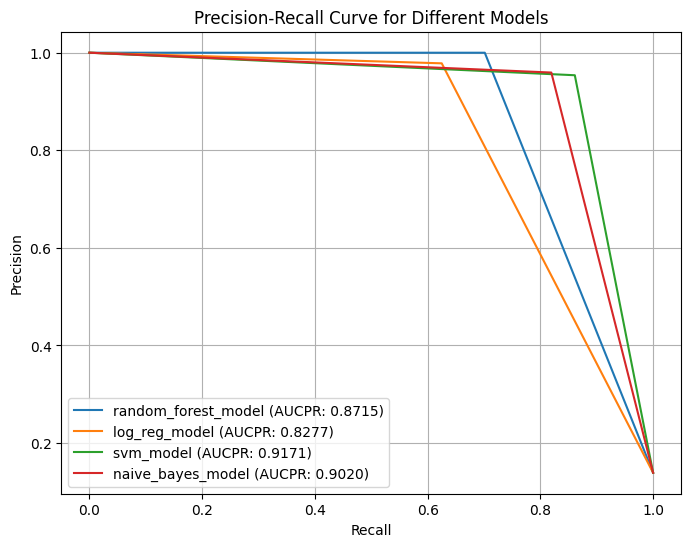

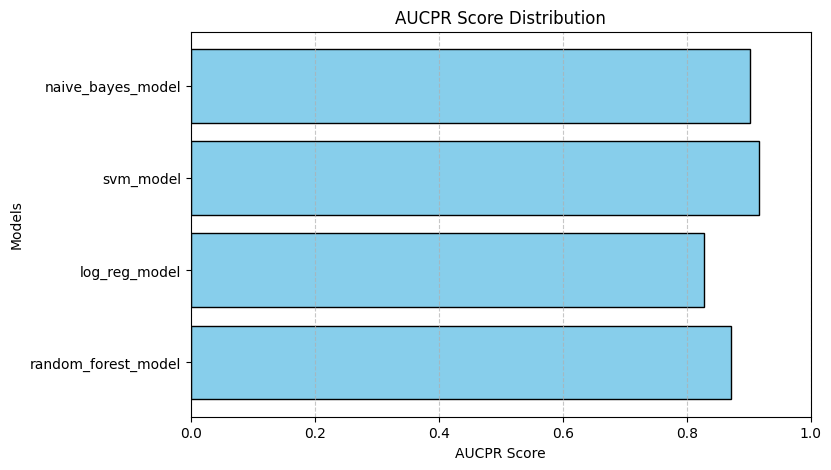

In [19]:
# Load all models from the specified MLflow run directory
models = os.listdir('runs/211292194086779681')

plt.figure(figsize=(8, 6))

aucpr_scores = []
model_names = []

for path in models:
    if path == 'meta.yaml':
        continue

    logged_model = f'runs:/{path}/model'
    model = mlflow.pyfunc.load_model(logged_model)

    # Extract model name from MLflow run metadata
    model_name = mlflow.get_run(path).data.tags.get("mlflow.runName", path)

    # Get predictions and convert to binary
    y_scores = model.predict(X_test)
    y_scores = (y_scores == 1).astype(int)
    
    # Convert true targets
    y_true = (test['target'] == 1).astype(int)

    # Compute precision, recall, and AUCPR
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    aucpr = auc(recall, precision)

    # Store values for histogram
    aucpr_scores.append(aucpr)
    model_names.append(model_name)

    # Print model name and AUCPR score
    print(f"Model: {model_name} | AUCPR: {aucpr:.4f}")

    # Plot precision-recall curve
    plt.plot(recall, precision, label=f"{model_name} (AUCPR: {aucpr:.4f})")

# Final plot formatting
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Different Models")
plt.legend()
plt.grid()
plt.show()

# Plot histogram of AUCPR scores
plt.figure(figsize=(8, 5))
plt.barh(model_names, aucpr_scores, color='skyblue', edgecolor='black')
plt.xlabel("AUCPR Score")
plt.ylabel("Models")
plt.title("AUCPR Score Distribution")
plt.xlim(0, 1)  # AUCPR ranges between 0 and 1
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()


## Support Vector Classifier is performing best
